<a href="https://colab.research.google.com/github/MUYang99/NOx-Time-Series-Prediction-Based-on-Deep-Learning/blob/main/Dtree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import sqrt
from numpy import concatenate
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import tree
from matplotlib import pyplot

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
# load dataset
dataset = pd.read_excel('d1.xlsx')
dataset.columns = ['Date', 'NOx']
dataset = dataset.dropna(subset=['NOx'])
dataset = dataset[dataset.Date < '20151231']
# normalise features
scaler = MinMaxScaler(feature_range=(0,1))
nox = dataset.NOx.values
nox = nox.reshape(len(nox), 1)
scaled = scaler.fit_transform(nox)
# frame as supervised learning
n_mins = 5
n_features = 1
reframed = series_to_supervised(scaled, n_mins, 1)
# drop columns we don't want to predict
print(reframed.shape)

(34171, 6)


In [4]:
# split into train and test sets
values = reframed.values
n_val_quarters = 144
train = values[:-n_val_quarters, :]
test = values[-n_val_quarters:, :]
# split into input and outputs
n_obs = n_mins * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X,  test_y =test[:, :n_obs], test[:,-1]
print(train_y,test_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[0.02625393 0.01492469 0.02059094 ... 0.08218856 0.11484521 0.08170986] [0.08624242 0.06924609 0.06411255 0.13508192 0.06733934 0.05603074
 0.05825792 0.09900063 0.07143672 0.05450959 0.04529853 0.05644195
 0.09153998 0.06544795 0.09489169 0.06451359 0.07885625 0.13490968
 0.10106907 0.07351168 0.09645039 0.08496614 0.10685232 0.11668166
 0.09611134 0.06053731 0.1144115  0.10744275 0.10498948 0.05373451
 0.04738202 0.06551398 0.07339522 0.0721457  0.03779676 0.0376547
 0.03838633 0.02951851 0.03366035 0.03605682 0.108373   0.03541588
 0.02780906 0.03884277 0.01732559 0.01929285 0.03071147 0.04080375
 0.03354544 0.02858344 0.01947758 0.01849698 0.01096363 0.0359212
 0.01333628 0.0329187  0.01522301 0.01641209 0.02182572 0.02357838
 0.05823433 0.02370485 0.01406209 0.01879956 0.01417133 0.01176672
 0.00937948 0.00670744 0.02474504 0.02234058 0.00968579 0.04660756
 0.03404036 0.04977019 0.05880467 0.06792015 0.10591198 0.09396764
 0.11937544 0.08175176 0.0684762  0.0438341  0.05763902 0.0

In [5]:
# design svm model
clf = tree.DecisionTreeRegressor()
# fit model
clf.fit(train_X,train_y)
# make a prediction
predict_y = clf.predict(test_X)
yhat = predict_y.reshape(predict_y.shape[0],1)
test_X = test_X.reshape((test_X.shape[0],n_mins*n_features))
print(yhat.shape,test_X.shape)

(144, 1) (144, 5)


In [6]:
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -24:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -24:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

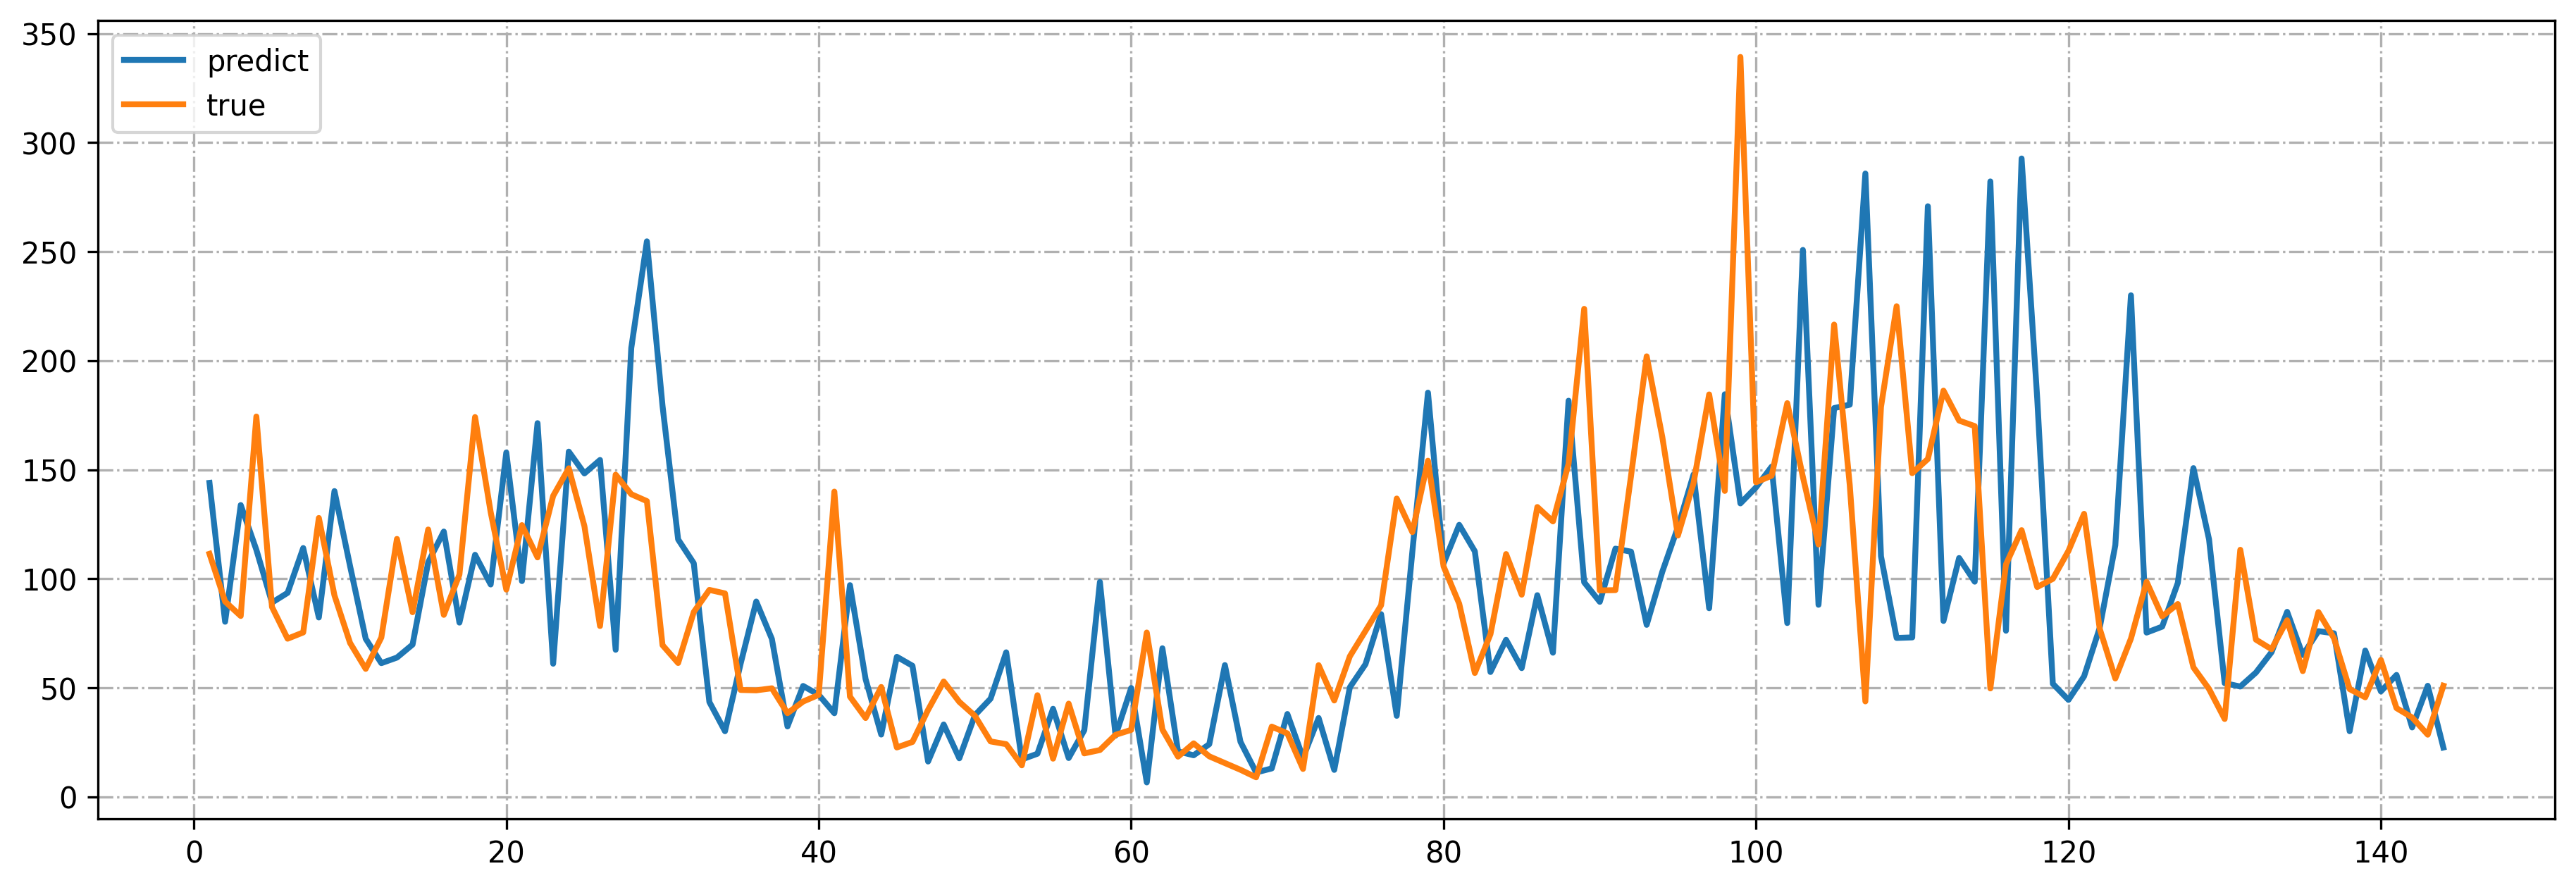

In [7]:
# plot 
fig, ax = pyplot.subplots(figsize=(15,5), dpi = 300)
ax.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linewidth=2.0, label = "predict")
ax.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linewidth=2.0, label = "true")
ax.legend(loc=2);
pyplot.grid(linestyle='-.')
pyplot.show()

In [8]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
# calculate MAE
MAE = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' %MAE)

Test RMSE: 62.056
Test MAE: 43.398
